In [2]:
require(tidyverse)
require(tidyr)
require(data.table)
require(gplots)
require(qqman)
require(pracma)
require(imputeTS)
require(corrplot)

# USC Glioma CoRSIV Capture Sequencing Read Depth Analysis

## Loading covariated files ...

In [3]:
USC_Sample_ID_table <- read.table("./USC_pediatric_glioma_alignments/sample_id_table1.txt",header = T)
Covariate_table <- read.table("./USC_pediatric_glioma_alignments/Baylor_covariate_file.txt",header = T)
temp_table <- merge(USC_Sample_ID_table,Covariate_table,by.x = "ID2",by.y = "Blindid")
temp_table$merged_col <- paste(temp_table$ID1,temp_table$Case_status,sep = "_")
temp_table <- temp_table[order(temp_table$ID1),]

### The covariates file looks like follows. This table will be used to identiy sample case / control status

In [4]:
head(temp_table)

,ID2,ID1,Case_status,Tumor_histology,Gender,Race,Matching_ID,merged_col
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<chr>
13,494147,USC_01,case,Glioblastoma,Male,white,3168123,USC_01_case
3,53755,USC_02,control,MATCHED_CONTROL,Male,white,2469312,USC_02_control
21,740189,USC_03,case,Glioblastoma,Male,white,2677136,USC_03_case
2,20438,USC_04,case,Anaplastic_astrocytoma,Male,white,4036151,USC_04_case
14,495067,USC_05,case,Glioblastoma,Female,white,3208750,USC_05_case
4,73887,USC_06,case,Anaplastic_astrocytoma,Female,white,1702653,USC_06_case


In [51]:
complete_bed_file <- read.table("./combined_corsivs.bed",sep = "\t")
head(complete_bed_file)

,V1,V2,V3,V4,V5
,<fct>,<int>,<int>,<fct>,<fct>
1,chr1,629021,629220,3f406877,chr1:629021-629220
2,chr1,630101,630700,c4a9f793,chr1:630101-630700
3,chr1,851901,852100,69cbdba1,chr1:851901-852100
4,chr1,1067501,1068200,fcf0cc7a,chr1:1067501-1068200
5,chr1,1289901,1290500,83d01f43,chr1:1289901-1290500
6,chr1,1378501,1378800,7e65a6f0,chr1:1378501-1378800


Read in complete set of bed files to R workspace. These bed files were create by using the script (./bash/corsiv_intersect_cov.sh). This location holds coverage files from bismark methylation extractor) The Alignment pipleline is avaialble in another note book.

```bash
for file in ./USC_pediatric_glioma_alignments/merged_CpG_eviddence/*.cov
do
        echo $(echo $(basename $file) | cut -f1 -d ".").bed
        bedtools intersect -a $file -b combined_corsivs.bed -wb > ./USC_pediatric_glioma_bed_file/$(echo $(basename $file) | cut -f1 -d ".").bed
done
```

In [5]:
files <- "./USC_pediatric_glioma_bed_file"
file_names <- dir(files,full.names = T,pattern = "*.bed")
df <- do.call(rbind,
              lapply(file_names, 
                     function(x) cbind(read.table(x),
                                       #name=strsplit(strsplit(x,'\\.')[[1]][2],"/")[[1]][6]
                                       name=paste0("USC_",strsplit(strsplit(x,split = "/")[[1]][3],split = "_")[[1]][2])
                     )
              )
)


In [6]:
head(df)
dim(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,name
,<fct>,<int>,<int>,<dbl>,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>
1,chr6,259989,259990,16.17852,116,601,chr6,259901,260600,81486841,chr6:259901-260600,USC_01
2,chr6,260086,260087,11.82635,79,589,chr6,259901,260600,81486841,chr6:259901-260600,USC_01
3,chr6,260153,260154,62.06897,324,198,chr6,259901,260600,81486841,chr6:259901-260600,USC_01
4,chr6,260211,260212,86.73267,438,67,chr6,259901,260600,81486841,chr6:259901-260600,USC_01
5,chr6,260336,260337,31.17117,173,382,chr6,259901,260600,81486841,chr6:259901-260600,USC_01
6,chr6,260543,260544,93.52227,462,32,chr6,259901,260600,81486841,chr6:259901-260600,USC_01


[1] 2207629      12

In [7]:
READ_DEPTH_CUTOFF = 10

In [25]:
individuals <- as.character(unique(df$name))
corsivs <- as.character(unique(df$V10))
corsiv_methy_df <- data.frame(matrix(nrow = length(corsivs),ncol = 0))
corsiv_depth_df <- data.frame(matrix(nrow = length(corsivs),ncol = 0))

for (individual in individuals){
    message(individual)
    #individual <- "USC_08"
    ind_df <- df[df$name==individual,]
    corsiv_methylation_values <-c()
    avg_depth_corsivs <- c()
    for(corsiv in corsivs){
        #corsiv="174aab9d"
        #print(paste0(individual,"--",corsiv))
        corsiv_df <- ind_df[ind_df$V10==corsiv,]
        corsiv_df$total <- corsiv_df$V5 + corsiv_df$V6
        nCpGs <- dim(corsiv_df)[1]
        
        if(nCpGs>2){
            corsiv_df <- corsiv_df[corsiv_df$total>=READ_DEPTH_CUTOFF,]
            if(dim(corsiv_df)[1] > ceil(nCpGs/2)){
                avg_depth_corsivs <- c(avg_depth_corsivs,1)
            }else{
                avg_depth_corsivs <- c(avg_depth_corsivs,0)
            }
            
        }else if(0 < nCpGs & nCpGs <=2 ){
            corsiv_df <- corsiv_df[corsiv_df$total>=READ_DEPTH_CUTOFF,]
            if(dim(corsiv_df)[1] == nCpGs){
                avg_depth_corsivs <- c(avg_depth_corsivs,1)
            }else{
                avg_depth_corsivs <- c(avg_depth_corsivs,0)
            }
        }else{
            avg_depth_corsivs <- c(avg_depth_corsivs,0)
        }
        
        corsiv_methylation_values <- c(corsiv_methylation_values, (sum(corsiv_df$V5)/sum(corsiv_df$total))*100)

    }
    corsiv_methy_df[individual] <- corsiv_methylation_values
    corsiv_depth_df[individual] <- avg_depth_corsivs
    message("Done")
}
rownames(corsiv_methy_df) <- corsivs
rownames(corsiv_depth_df) <- corsivs

USC_01

Done

USC_02

Done

USC_03

Done

USC_04

Done

USC_05

Done

USC_06

Done

USC_07

Done

USC_08

Done

USC_09

Done

USC_10

Done

USC_11

Done

USC_12

Done

USC_13

Done

USC_14

Done

USC_15

Done

USC_16

Done

USC_17

Done

USC_18

Done

USC_19

Done

USC_20

Done

USC_21

Done

USC_22

Done

USC_23

Done

USC_24

Done



[1] 10413

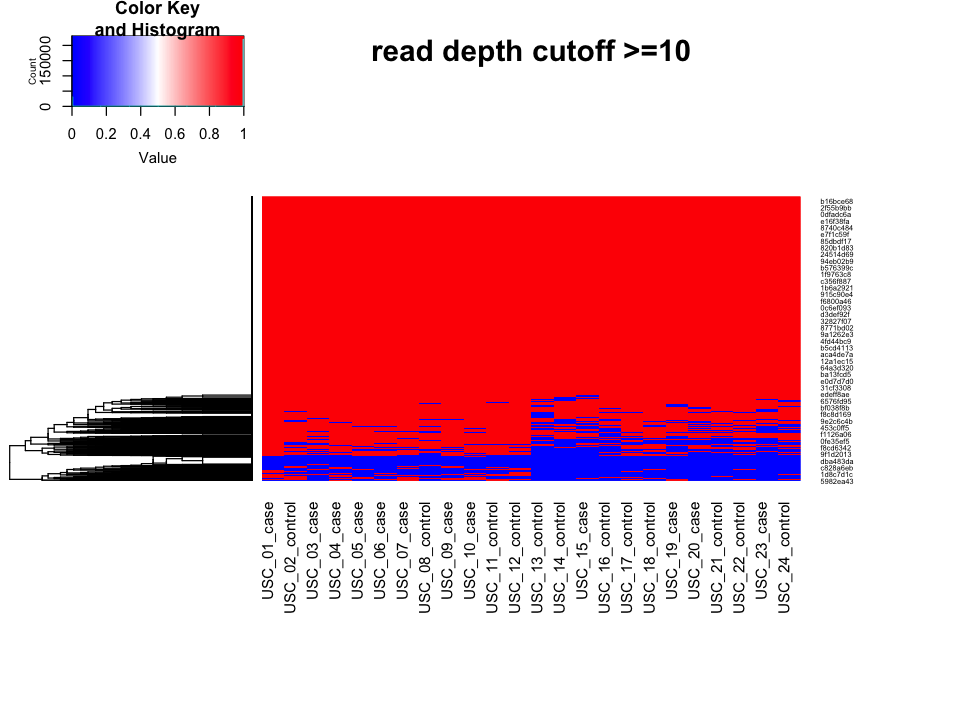

In [31]:
options(repr.plot.width=8, repr.plot.height=6)
dim(corsiv_depth_df)[1]
colnames(corsiv_depth_df) <- temp_table$merged_col

my_palette <- colorRampPalette(c("blue", "white", "red"))(n = 299)
depth_data <- as.matrix(corsiv_depth_df)
#depth_data <- depth_data>=10
#depth_data[is.na(depth_data)] <- 0
#depth_data <- 1*depth_data

heatmap.2(depth_data,trace="none",dendrogram = "row",margins=c(12,8),col=my_palette,main = "read depth cutoff >=10",Colv="NA")


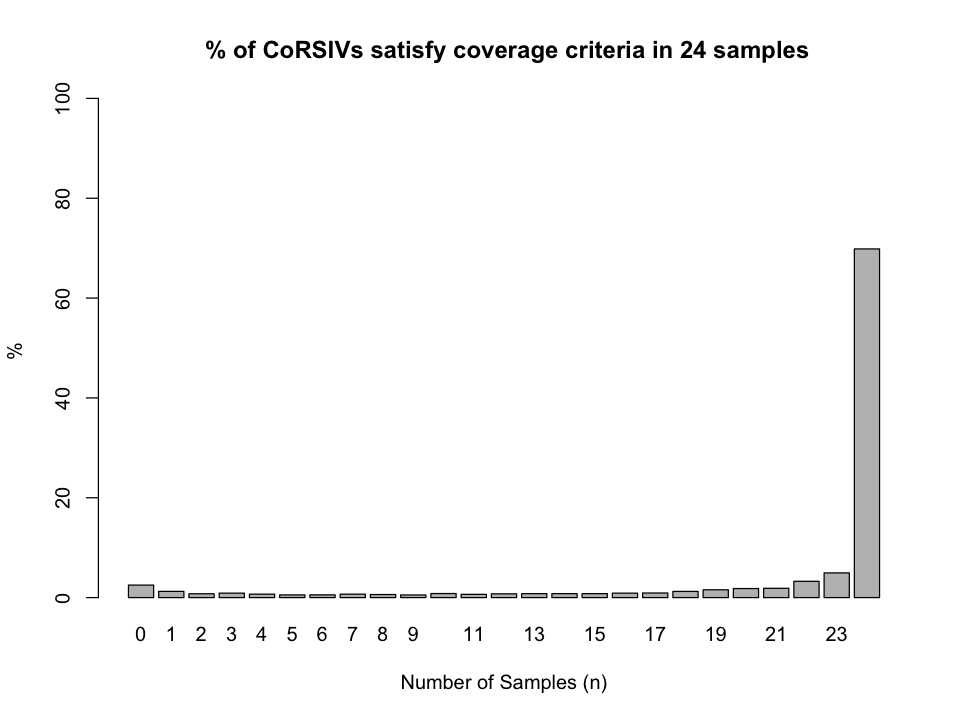

In [37]:

corsiv_covered_by_samples <- data.frame(rowSums(depth_data))
corsiv_covered_by_samples$CoRSIV_Id <- rownames(corsiv_covered_by_samples)
rownames(corsiv_covered_by_samples) <- NULL
colnames(corsiv_covered_by_samples) <- c("nSamples","CoRSIV_Id")

barplot((table(corsiv_covered_by_samples$nSamples)/dim(corsiv_depth_df)[1])*100,ylim = c(0,100),
        ylab = "% ",xlab="Number of Samples (n)", main = " % of CoRSIVs satisfy coverage criteria in 24 samples")


selected_corsivs <- corsiv_covered_by_samples[corsiv_covered_by_samples$nSamples>19,]$CoRSIV_Id


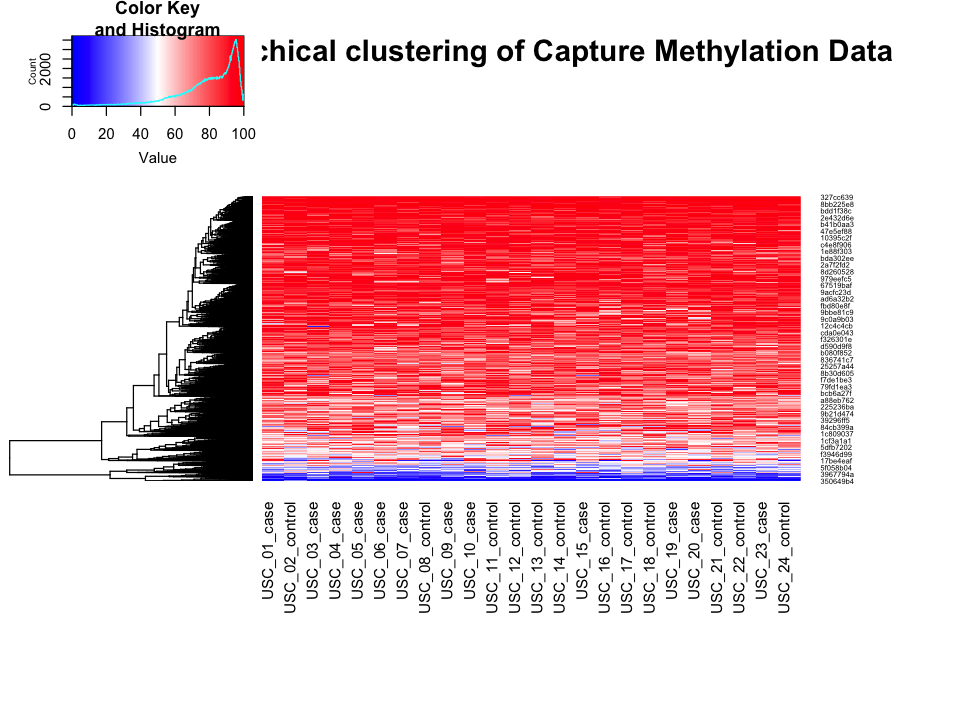

In [38]:
corsiv_methy_df_subset <- subset(corsiv_methy_df,rownames(corsiv_methy_df) %in% selected_corsivs)

colnames(corsiv_methy_df_subset) <-  temp_table$merged_col

corsiv_methy_df_subset <- na_mean(corsiv_methy_df_subset)
heatmap.2(as.matrix(corsiv_methy_df_subset),trace="none",
          dendrogram = "row",margins=c(12,8),col=my_palette,main = "hierarchical clustering of Capture Methylation Data",Colv = NA)


In [41]:
corsiv_methy_df_subset <- corsiv_methy_df_subset[c(
     sort(grep("control",colnames(corsiv_methy_df_subset))),sort(grep("case",colnames(corsiv_methy_df_subset)))
     )]
head(corsiv_methy_df_subset)

,USC_02_control,USC_08_control,USC_11_control,USC_12_control,USC_13_control,USC_14_control,USC_16_control,USC_17_control,USC_18_control,USC_21_control,⋯,USC_04_case,USC_05_case,USC_06_case,USC_07_case,USC_09_case,USC_10_case,USC_15_case,USC_19_case,USC_20_case,USC_23_case
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
81486841,43.39927,33.93316,43.35640,40.48607,35.27607,43.58162,38.95411,40.07463,45.31307,41.00550,⋯,40.09217,43.62416,42.18750,40.60629,44.25770,38.76342,37.55622,37.15309,38.93077,44.62565
eeb3d394,88.60759,92.84116,92.85714,93.75000,92.14437,91.44095,95.78947,91.82597,90.82724,90.70322,⋯,92.60870,91.31854,93.49872,88.42857,91.80791,89.70037,90.48649,94.06528,91.09357,89.53488
dc06f737,60.98736,74.15414,65.67303,72.33480,66.74641,60.41940,70.10135,60.47904,61.15892,63.10260,⋯,71.39875,58.80026,70.00000,56.57265,72.04861,66.87752,64.49360,73.81371,65.51078,64.89796
01d9474e,86.31732,90.00000,87.47698,89.20635,86.32479,90.16018,87.59690,87.41543,88.85906,90.07804,⋯,89.72746,90.16760,86.39653,85.74822,87.58065,90.04283,91.77215,86.09023,84.32304,92.51701
10349a81,77.59303,95.42484,85.84320,74.32188,85.02674,82.37885,93.58601,89.22212,81.27341,82.12121,⋯,84.31215,80.67400,88.29932,77.00935,82.00873,72.83269,83.33333,95.15012,83.96825,85.68738
60895049,77.60885,94.59042,88.21855,78.94131,80.00000,83.78713,94.97608,88.55586,90.43948,89.85240,⋯,85.73928,82.23827,96.21137,82.52671,88.11881,85.47963,86.37911,97.33060,90.23669,91.11842


In [42]:
t.result <- apply(corsiv_methy_df_subset, 1, function (x) t.test(x[1:12],x[13:24],paired=TRUE))
corsiv_methy_df_subset$p_value <- unlist(lapply(t.result, function(x) x$p.value))
corsiv_methy_df_subset$p_value <- corsiv_methy_df_subset$p_value
corsiv_methy_df_subset$fdr <- p.adjust(corsiv_methy_df_subset$p_value, method = "holm")
corsiv_methy_df_subset$CoRSIV_ID <- rownames(corsiv_methy_df_subset)


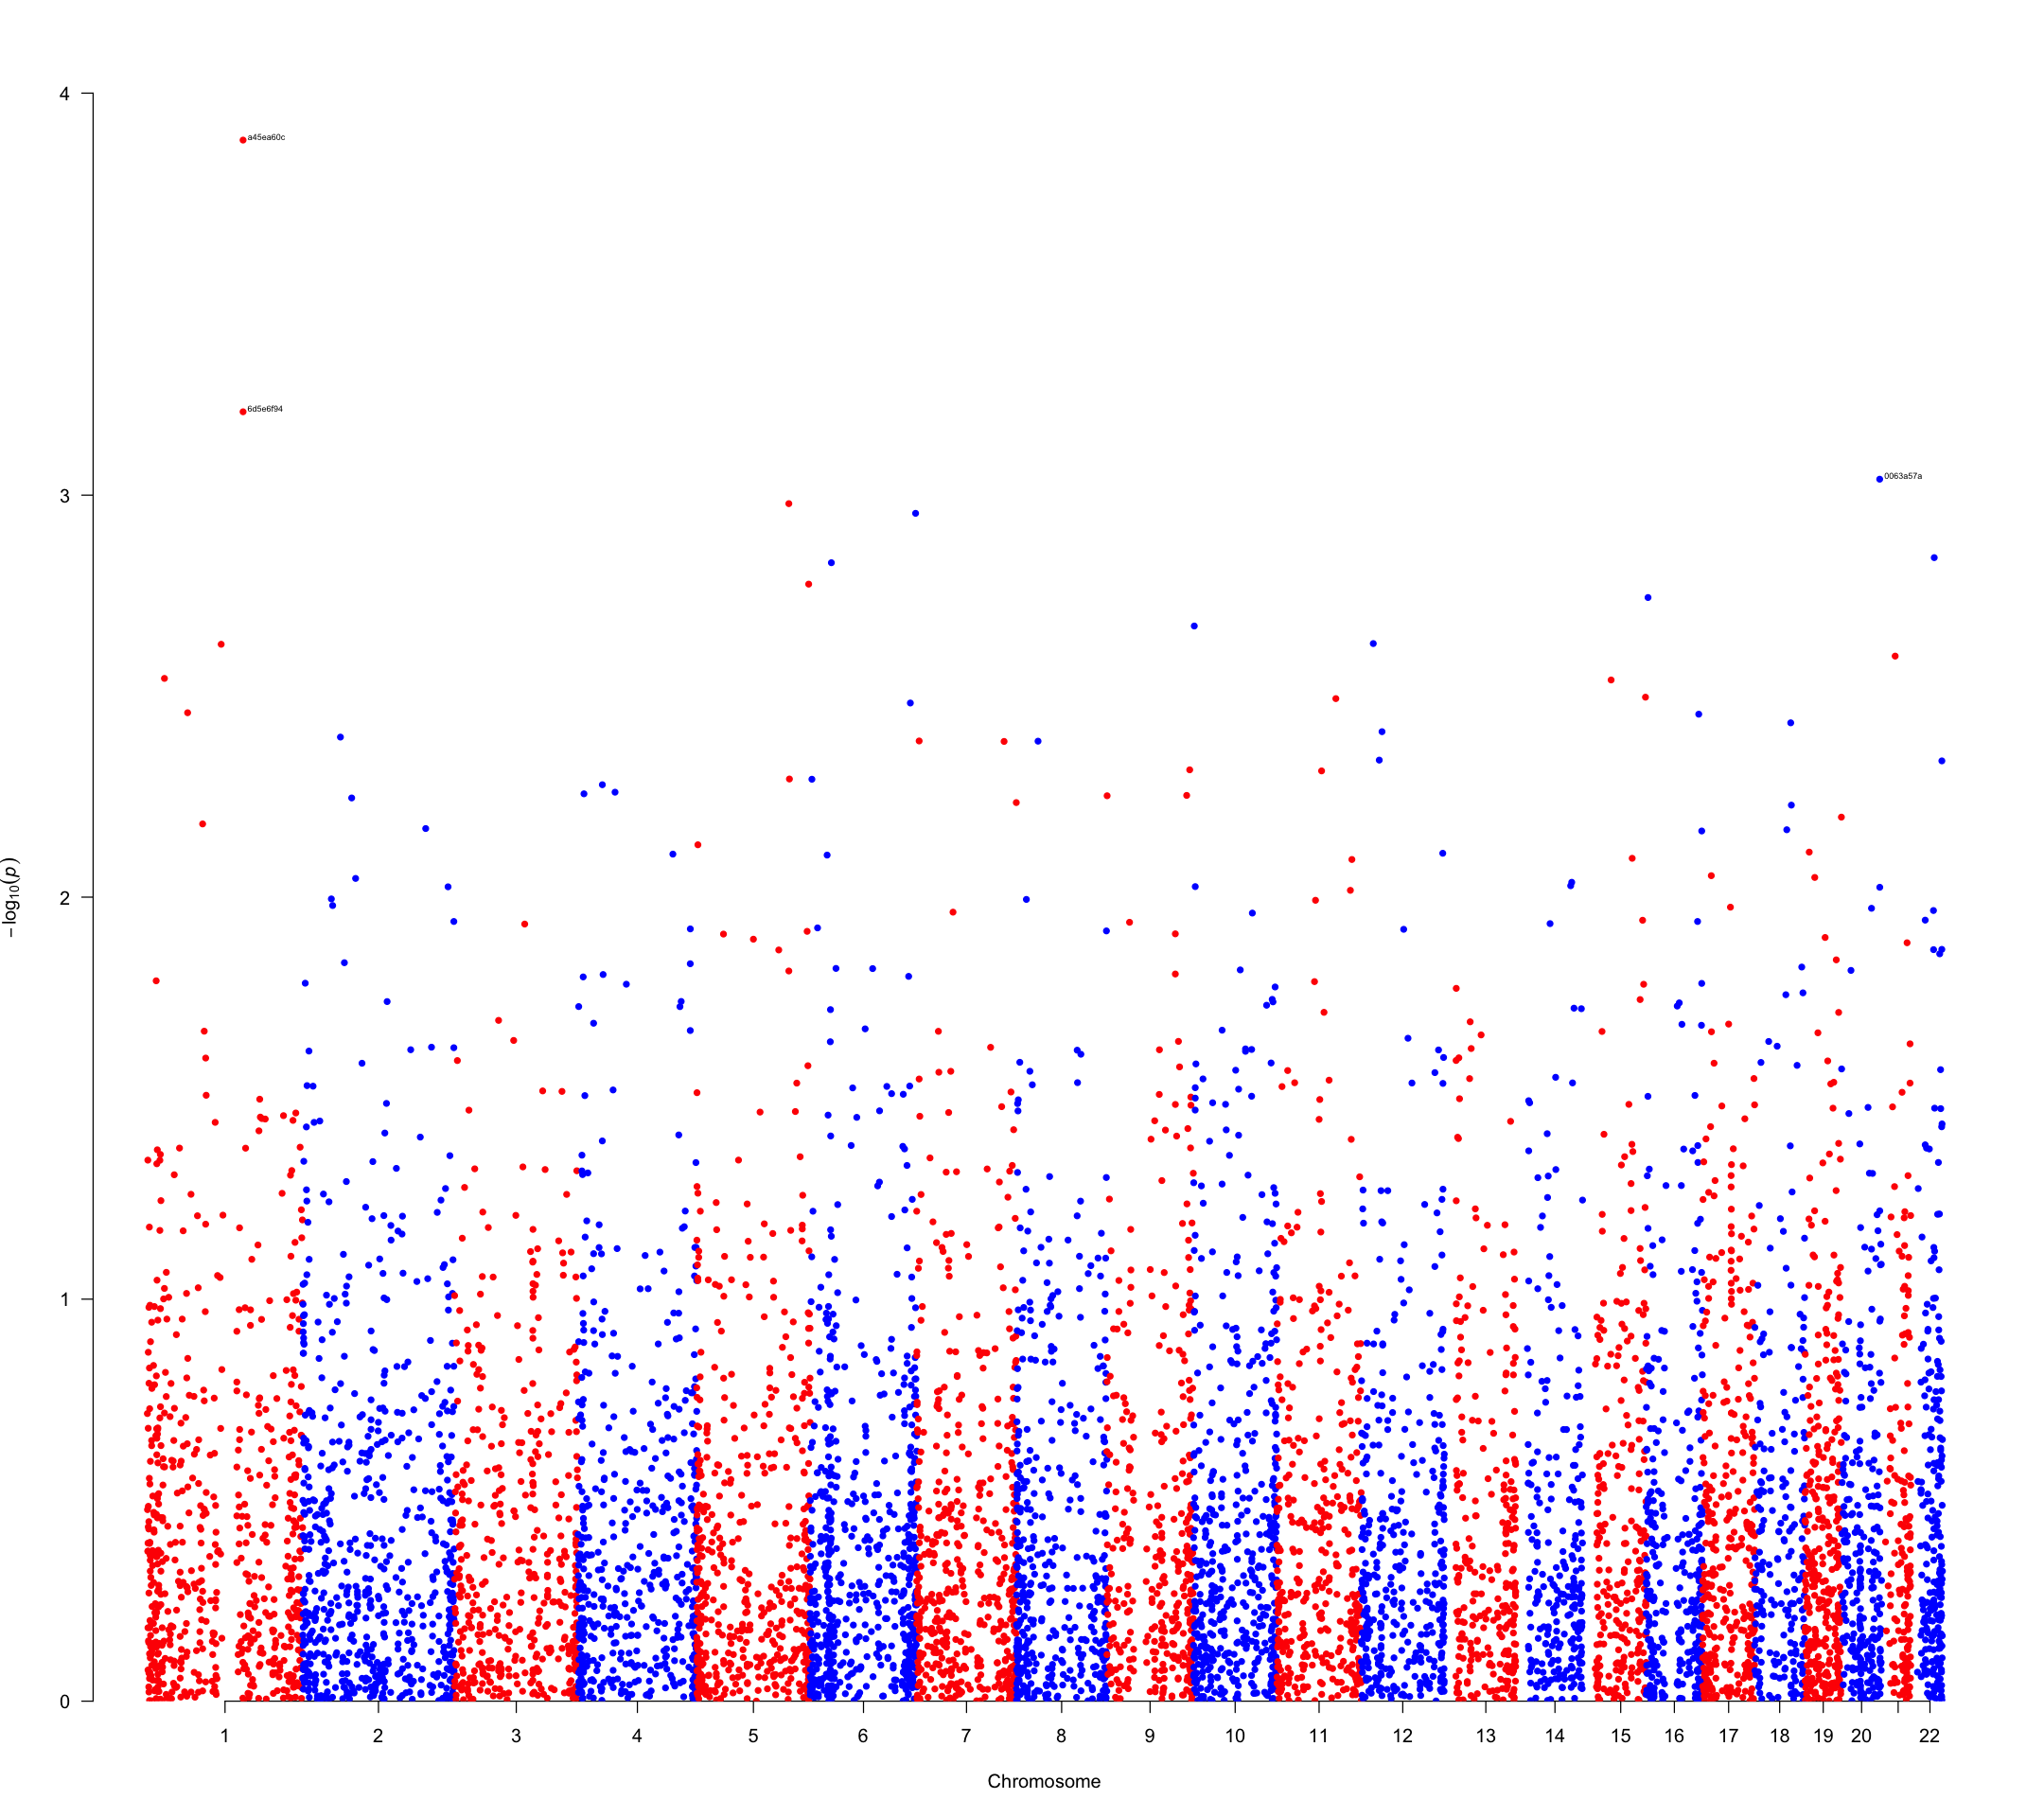

In [47]:
to_manhattan <- corsiv_methy_df_subset[c("CoRSIV_ID","p_value")]
to_manhattan <- merge(to_manhattan,complete_bed_file,by.x = "CoRSIV_ID",by.y = "V4")
to_manhattan <- to_manhattan[c("CoRSIV_ID","V1","V2","p_value")]
colnames(to_manhattan) <- c("SNP","CHR","BP","P")
#strtoi(substring(to_manhattan$CHR, 4),10)
to_manhattan$CHR <- strtoi(substring(to_manhattan$CHR, 4),10)
to_manhattan$BP <- as.numeric(to_manhattan$BP)
to_manhattan <- na.omit(to_manhattan)
options(repr.plot.width=18, repr.plot.height=16)
manhattan(to_manhattan, chr="CHR", bp="BP", snp="SNP", p="P",
          suggestiveline = FALSE,col = c("red","blue"),
          annotatePval = 0.001,annotateTop = F)


In [48]:
corsiv_methy_df_subset$CoRSIV_ID <- rownames(corsiv_methy_df_subset)
corsiv_methy_df_subset <- merge(corsiv_methy_df_subset,complete_bed_file,by.x ="CoRSIV_ID",by.y = "V4",no.dups = T,all.x = T)
corsiv_methy_df_subset$V1 <- strtoi(substring(corsiv_methy_df_subset$V1, 4),10)
corsiv_methy_df_subset <- corsiv_methy_df_subset[
    with(corsiv_methy_df_subset, order(V1,V3)),
    ]


In [49]:
corsiv_methy_df_subset

,CoRSIV_ID,USC_02_control,USC_08_control,USC_11_control,USC_12_control,USC_13_control,USC_14_control,USC_16_control,USC_17_control,USC_18_control,⋯,USC_15_case,USC_19_case,USC_20_case,USC_23_case,p_value,fdr,V1,V2,V3,V5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>
2104,3f406877,91.35802,94.189602,97.11316,92.780749,95.13889,100.000000,94.285714,94.40789,98.418972,⋯,96.885813,98.59155,97.933884,82.90598,0.19257765,1,1,629021,629220,chr1:629021-629220
3539,69cbdba1,87.75244,86.185725,87.08241,86.894442,84.86172,82.357533,90.240642,86.44068,85.866477,⋯,86.274510,83.20935,82.517483,87.51334,0.33384470,1,1,851901,852100,chr1:851901-852100
4395,83d01f43,86.68407,92.329431,78.86477,84.954407,89.94365,89.392643,92.657551,79.42719,42.410714,⋯,94.707147,72.22222,77.236581,87.48293,0.42388580,1,1,1289901,1290500,chr1:1289901-1290500
4197,7e65a6f0,96.08501,95.806029,95.50989,94.440811,94.81947,93.195876,95.099541,97.32977,95.212766,⋯,93.648449,94.98018,94.070513,92.69663,0.04510407,1,1,1378501,1378800,chr1:1378501-1378800
4266,8035ad5a,75.14151,45.745993,45.17598,63.835839,65.53672,61.420205,55.584416,42.69883,75.324028,⋯,75.332811,47.94069,54.623656,75.40650,0.65682470,1,1,1575701,1576100,chr1:1575701-1576100
7926,eed4ff42,90.15651,96.282652,81.96156,91.523747,92.61926,95.772595,92.885691,97.58339,96.550716,⋯,96.365580,80.43893,91.630592,96.23588,0.40440909,1,1,1651401,1651600,chr1:1651401-1651600
7547,e2e86b78,80.25276,90.569395,70.97187,86.431479,84.21053,98.116761,82.422803,92.41245,95.425868,⋯,94.774347,71.64179,85.632184,88.69565,0.83652850,1,1,1653801,1654000,chr1:1653801-1654000
7827,ec16fbc3,85.37439,96.782666,90.40968,77.427335,83.37029,92.044064,94.743276,95.97315,92.223650,⋯,89.344262,91.83673,94.181460,92.49147,0.42331238,1,1,1688101,1688400,chr1:1688101-1688400
903,1aa3dba5,40.50179,51.225490,58.60927,44.880174,0.00000,49.806950,48.066298,50.85158,49.307479,⋯,27.272727,55.00000,53.012048,53.71179,0.20948586,1,1,1967301,1967600,chr1:1967301-1967600


In [50]:
write.csv(corsiv_methy_df_subset,
          file="./USC_pediatric_glioma_CoRSIV_Methylation_Data_10x_Depth_.csv",
          row.names=F,quote=F)